In [42]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization, Input, Layer, Dropout
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.regularizers import L2, L1
import seaborn as sns

# Data Preparation

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info= True, as_supervised= True, shuffle_files= True, split=['train'])

In [3]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

In [4]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):

  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))

  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

In [5]:
train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
# print(list(train_dataset.as_numpy_iterator()))
# print(list(val_dataset.as_numpy_iterator()))
# print(list(test_dataset.as_numpy_iterator()))

# Data Visualization

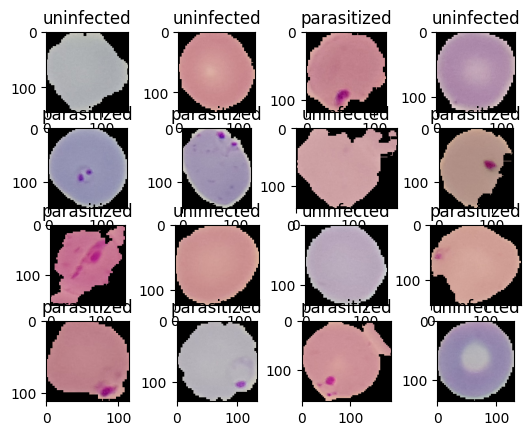

In [6]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))

# Data Processing

also we need to resize the images to fix size

there are 2 options standardizing the datas and normalizing the datas

if the images revolves around a particular mean value then we need to use standardization
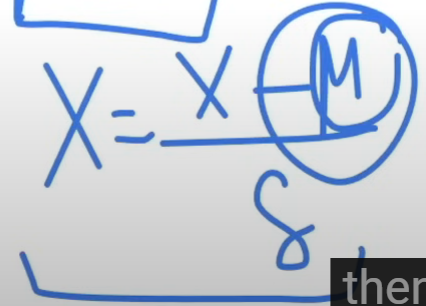


but if the data is or image sizes are mostly different from each other then we would want to normalize

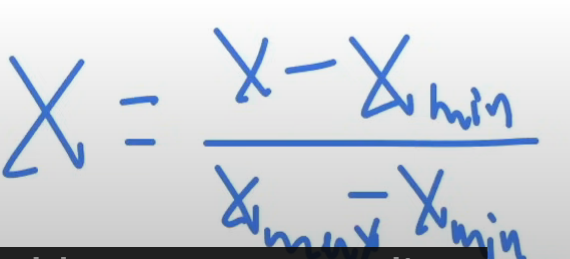

In [7]:
for x in train_dataset.take(1):
    print(type(x))
    if isinstance(x, tuple):
        print("Image shape:", x[0].shape)
        print("Label:", x[1])
    else:
        print("Sample shape:", x.shape)

<class 'tuple'>
Image shape: (103, 103, 3)
Label: tf.Tensor(1, shape=(), dtype=int64)


In [8]:
IM_SIZE = 224
def resizing_rescale(image,label):
  return  tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [9]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)

In [10]:
for image,label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [11]:
train_dataset = train_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration= True).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration= True).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration= True).batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Custom Layer

In [13]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super().__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
    self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)

  def call(self, input_features):
    if(self.activation == "relu"):
      return tf.nn.relu(tf.matmul(input_features, self.w) + self.b)

    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(tf.matmul(input_features, self.w) + self.b)

    else:
      return tf.matmul(input_features, self.w) + self.b

example:


In [44]:
dropout_rate = 0.3
regularization_rate = 0.01
lenet_custom_model = tf.keras.Sequential([
    InputLayer(shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 5, strides = 1 , padding = 'valid', activation = 'relu',
            kernel_regularizer = L2(regularization_rate) ),

    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    Dropout(rate = dropout_rate),

    Conv2D(filters = 16, kernel_size = 5, strides = 1 , padding = 'valid', activation = 'relu' ,
              kernel_regularizer = L2(regularization_rate)),

    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    NeuralearnDense(100, activation = "relu"),#custom dense layer
    BatchNormalization(),
    Dropout(rate = dropout_rate),
    NeuralearnDense(10, activation = "relu"),#custom dense layer
    BatchNormalization(),
    NeuralearnDense(1, activation = "sigmoid"),#custom dense layer


])

lenet_custom_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 220, 220, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 220, 220, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 106, 106, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 44944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense_12             │ (None, 100)            │     4,494,500 │
│ (NeuralearnDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense_13             │ (None, 10)             │         1,010 │
│ (NeuralearnDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense_14             │ (None, 1)              │            11 │
│ (NeuralearnDense)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

# Modelling

BatchNormalization - values of the same batch are standardize

**Sequential Api**

In [15]:
lenet_model = tf.keras.Sequential([
    InputLayer(shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 5, strides = 1 , padding = 'valid', activation = 'relu' ),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 5, strides = 1 , padding = 'valid', activation = 'relu' ),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    Dense(100, activation = "relu"),
    BatchNormalization(),
    Dense(10, activation = "relu"),
    BatchNormalization(),
    Dense(1, activation = "sigmoid"),


])

lenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 220, 220, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 220, 220, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 106, 106, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 44944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,494,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

**Functional Api**

In [16]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 5, strides = 1 , padding = 'valid', activation = 'relu' )(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Conv2D(filters = 16, kernel_size = 5, strides = 1 , padding = 'valid', activation = 'relu' )(x)
x = BatchNormalization()(x)

output = MaxPool2D(pool_size = 2, strides = 2)(x)

feature_extractor_model = Model(func_input, output, name = "Feautre_Extractor")
feature_extractor_model.summary()

Model: "Feautre_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 220, 220, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 220, 220, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 106, 106, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,960 (11.56 KB)

 Trainable params: 2,916 (11.39 KB)

 Non-trainable params: 44 (176.00 B)

In [17]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_model(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()


Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Feautre_Extractor (Functional)  │ (None, 53, 53, 16)     │         2,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 44944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,494,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

**Model Subclassing**

In [18]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides , padding = padding, activation = activation )
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size = pool_size, strides = strides*2 )

    self.conv_2 = Conv2D(filters = filters * 2, kernel_size = kernel_size, strides = strides , padding = padding, activation = activation  )
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size = pool_size, strides = strides*2)

  def call(self, x):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [19]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor               │ (None, 54, 54, 16)     │         1,488 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

In [20]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed_model = LenetModel()
lenet_sub_classed_model(tf.zeros([1,224,224,3]))
lenet_sub_classed_model.summary()

Model: "lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_extractor_1             │ ?                      │         1,488 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (1, 46656)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (1, 100)               │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (1, 100)               │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (1, 10)                │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (1, 10)                │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (1, 1)                 │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

# Model Training

overfitting
-is when you have less data and your model is complex that when in training it is good but when in validation it produces bad results

to mitigate OF
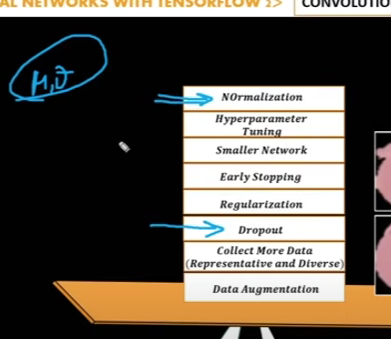

underfittting
-is when you have a lot of data but your model is too simple

to mitigate UF

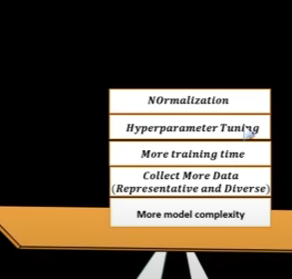

In [21]:
metrics =[
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'),
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    AUC(name='prc', curve='PR'), # precision-recall curve
]

In [22]:
lenet_custom_model.compile(
    optimizer = Adam(learning_rate = 0.1),
    loss = BinaryCrossentropy(),
    metrics = metrics
)

Learning Rate Scheduler

In [23]:
def scheduler(epoch, lr):
  if(epoch < 3):
    return lr
  else:
    return lr * tf.math.exp(-0.1).numpy()

schduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

Model Checkpointing

In [24]:


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/model_epoch_{epoch:02d}.keras',  # must include a filename if save_best_only=True
    monitor='val_loss',                     # metric to monitor
    verbose=1,                              # show messages when saving
    save_best_only=False,                     # only save the model if the monitored metric improves
    save_weights_only=False,                 # save the full model (architecture + weights)
    mode=3,                             # 'auto', 'min', or 'max'
    save_freq='epoch'                        # can be 'epoch' or an integer (batch frequency)
)


/tmp/ipython-input-646138503.py:1: UserWarning: ModelCheckpoint mode '3' is unknown, fallback to auto mode.
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(


Plateau callback

In [25]:
plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose = 1
)

In [26]:
history = lenet_custom_model.fit(train_dataset, validation_data= val_dataset, epochs= 10, verbose = 1, callbacks = [plateau_callback])

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 56s 91ms/step - accuracy: 0.7297 - auc: 0.7986 - fn: 789.9846 - fp: 998.7104 - loss: 0.5108 - prc: 0.7907 - precision: 0.7221 - recall: 0.7597 - tn: 3141.6467 - tp: 3373.5579 - val_accuracy: 0.8949 - val_auc: 0.9488 - val_fn: 29.0000 - val_fp: 550.0000 - val_loss: 0.2781 - val_prc: 0.9133 - val_precision: 0.8324 - val_recall: 0.9895 - val_tn: 2200.0000 - val_tp: 2732.0000 - learning_rate: 0.1000
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9364 - auc: 0.9616 - fn: 193.7664 - fp: 357.0888 - loss: 0.2140 - prc: 0.9506 - precision: 0.9200 - recall: 0.9572 - tn: 3783.1294 - tp: 3969.9150 - val_accuracy: 0.9316 - val_auc: 0.9659 - val_fn: 55.0000 - val_fp: 322.0000 - val_loss: 0.2217 - val_prc: 0.9554 - val_precision: 0.8939 - val_recall: 0.9801 - val_tn: 2422.0000 - val_tp: 2712.0000 - learning_rate: 0.1000
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.9392 - auc: 0.9668 - fn: 131.8668 - fp: 389.5463 - los

/tmp/ipython-input-200543154.py:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('train_loss', 'val_loss')


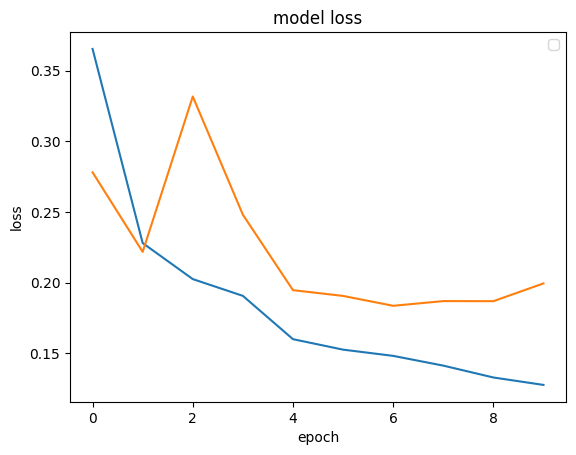

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train_loss', 'val_loss')
plt.show()

/tmp/ipython-input-1673357819.py:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('train',  'val_accuracy')


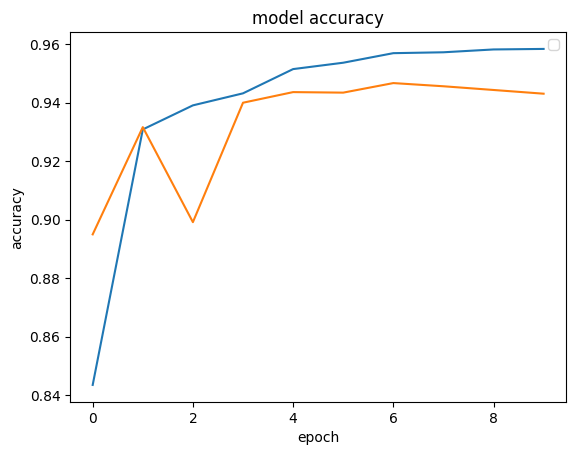

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend('train',  'val_accuracy')
plt.show()

# Model Evaluation and Testing

In [29]:
lenet_custom_model.evaluate(test_dataset)

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9454 - auc: 0.9769 - fn: 47.0402 - fp: 110.6034 - loss: 0.1828 - prc: 0.9694 - precision: 0.9260 - recall: 0.9690 - tn: 1281.7701 - tp: 1360.1379


[0.1966441571712494,
 2655.0,
 222.0,
 2536.0,
 100.0,
 0.9415925741195679,
 0.9228363037109375,
 0.963702380657196,
 0.973833441734314,
 0.9629087448120117]

Visualizaing Confusion Matrix

In [30]:
import numpy as np

# Concatenate all image batches
inputs = np.concatenate([x for x, y in test_dataset.as_numpy_iterator()], axis=0)

# Concatenate all label batches
labels = np.concatenate([y for x, y in test_dataset.as_numpy_iterator()], axis=0)

print("inputs shape:", inputs.shape)
print("labels shape:", labels.shape)


inputs shape: (5513, 224, 224, 3)
labels shape: (5513,)


In [31]:
p = lenet_custom_model.predict(inputs)

173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


[[1349 1408]
 [1284 1472]]


Text(0.5, 25.722222222222214, 'Predicted label')

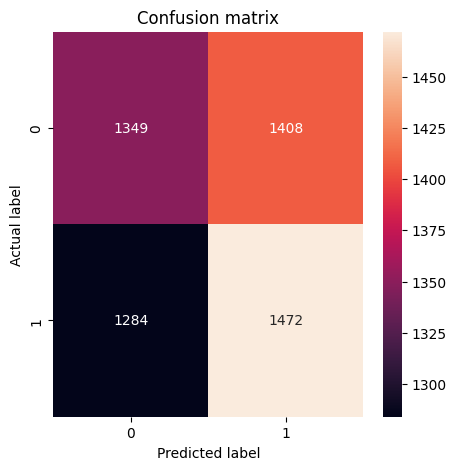

In [32]:
threshold = 0.5

cm = confusion_matrix(labels, p > threshold)
print(cm)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

ROC plots


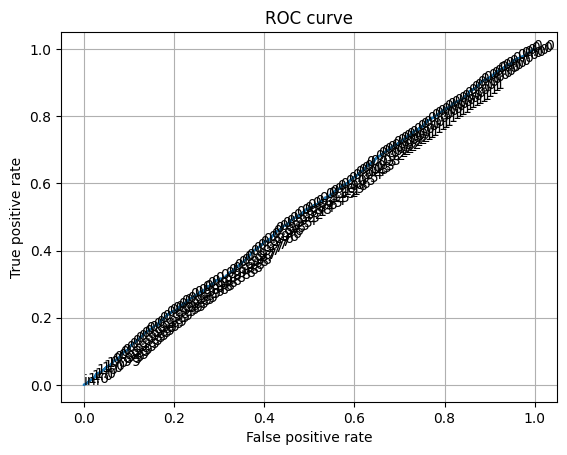

In [33]:
# Get predicted probabilities for the positive class
y_probs = p  # shape: (num_samples, 1) or (num_samples,)
# Ensure 1D array
y_probs = y_probs.ravel()

# Compute ROC curve
fp, tp, thresholds = roc_curve(labels, y_probs)

plt.plot(fp, tp, label="ROC curve")
plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

# Annotate thresholds every 'skip' points
skip = 20
for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], str(round(thresholds[i], 2)))

plt.grid()
plt.show()

In [34]:
def parasite_or_not(x):
  if(x < 0.5):
    return str('P')

  else:
    return str('U')

In [35]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


'P'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


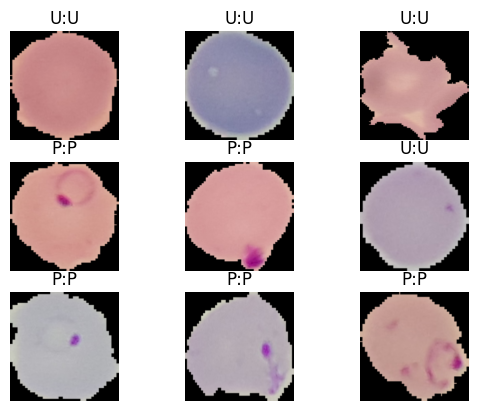

In [36]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot( 3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" +str(parasite_or_not(lenet_custom_model.predict(image)[0][0])))

  plt.axis('off')